In [1]:
import requests
import json

betydb = "http://www.betydb.org/api/beta"

In [2]:
import pandas as pd


In [3]:
s4_df = pd.read_csv('/Users/curtislisle/Dropbox/ipython-notebooks/D3M/TERRA/terraref_r/season4date.csv')

/Users/curtislisle/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
s4_df.head()['sitename']

0     MAC Field Scanner Season 4 Range 8 Column 8
1     MAC Field Scanner Season 4 Range 8 Column 9
2    MAC Field Scanner Season 4 Range 8 Column 10
3    MAC Field Scanner Season 4 Range 8 Column 12
4     MAC Field Scanner Season 4 Range 9 Column 3
Name: sitename, dtype: object

In [5]:
s4_df.columns

Index(['Unnamed: 0', 'checked', 'result_type', 'id', 'citation_id', 'site_id',
       'treatment_id', 'sitename', 'city', 'lat', 'lon', 'scientificname',
       'commonname', 'genus', 'species_id', 'cultivar_id', 'author',
       'citation_year', 'treatment', 'date', 'time', 'raw_date', 'month',
       'year', 'dateloc', 'trait', 'trait_description', 'mean', 'units', 'n',
       'statname', 'stat', 'notes', 'access_level', 'cultivar', 'entity',
       'method_name', 'view_url', 'edit_url', 'trans_date'],
      dtype='object')

In [20]:
selected = ['id','cultivar','cultivar_id','date','trans_date','sitename','trait','mean','units']
s4sel = s4_df[selected]

In [21]:
s4sel.head()

,id,cultivar,cultivar_id,date,trans_date,sitename,trait,mean,units
0,6004764469,PI570145,6000000961,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 8,canopy_height,13.0,cm
1,6004764470,PI329510,6000000577,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 9,canopy_height,14.0,cm
2,6004764471,PI510757,6000000850,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 10,canopy_height,12.0,cm
3,6004764473,PI329865,6000000815,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 12,canopy_height,13.0,cm
4,6004764478,PI569457,6000000935,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,14.0,cm


 If all the measurements were equally distributed, doing a long to wide rollup mechanically using pandas' pivot would work.  However, some measurements started later and ended earlier.  Some measurements are daily, some are hourly (just in August), so we really need to split up this dataset into major subsets:  daily and hourly, then try to pivot these datasets.  Or worse, have to hand convert the entries.  I elected to just write a custom algorithm to gather all the measurements together, indexed by date. 

Write a routine that pivots/rolls up the data by hand, by creating a dictionary with trans_date as its index.  Then we can add measurements one at a time...

In [8]:
s4hand = {}
count = 0
for i in range(len(s4sel)):
    #if count > 40:
    #    break
    #print(i,s4sel['trans_date'][i])
    
    # if we have never seen this date before, start a new dictionary at this date
    if s4sel['trans_date'][i] not in s4hand.keys():
        s4hand[s4sel['trans_date'][i]] = {}

    # if we have not seen this cultivar before on this date, then add a dictionary for this cultivar.  Is there is a chance we 
    # might lose records here? 
    if s4sel['cultivar_id'][i] not in s4hand[s4sel['trans_date'][i]].keys():
        s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]] = {}
        
    # add this feature to the dictionary for the correct cultivar on this date.  We add a dictionary entry named 
    # from the contents in the 'trait' attribute and pull the value from the 'mean' attribute.  This is the heart
    # of the long to wide format conversion.
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]][s4sel['trait'][i]] = s4sel['mean'][i]
    
    # add the cultivar and the location (split out from the sitename text).  This will be added multiple times,
    # so represents redundant processing, but it works to place the measurements in cultivar and location
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['cultivar_id'] = s4sel['cultivar_id'][i]
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['season'] = int(s4sel['sitename'][i].split(' ')[4])
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['range'] = int(s4sel['sitename'][i].split(' ')[6])
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['column'] = int(s4sel['sitename'][i].split(' ')[8])
    count += 1
print('entered ',count, 'measurements')


entered  372363 measurements


In [22]:
print('how many different datetime events:')
print(len(s4hand.keys()))
#print(s4hand.keys())
print('print ouf the wide tuple of a particular cultivar at a particular datetime:')
print(s4hand['2017-07-08 12:00:00'][6000000861])
print(s4hand['2017-08-08 12:00:00'][6000000861])

how many different datetime events:
3152
print ouf the wide tuple of a particular cultivar at a particular datetime:
{'canopy_height': 192.0, 'season': 4, 'range': 46, 'column': 3, 'leaf_angle_mean': 0.46521782152400004, 'leaf_angle_alpha': 1.6835253597400002, 'leaf_angle_beta': 1.4356619889500002, 'leaf_angle_chi': 1.71004921126, 'cultivar': 6000000861, 'date': '2017-07-08 12:00:00'}
{'canopy_height': 293.0, 'season': 4, 'range': 46, 'column': 3, 'leaf_angle_mean': 0.460059049579, 'leaf_angle_alpha': 1.80939043311, 'leaf_angle_beta': 1.5116882921700001, 'leaf_angle_chi': 1.7059298014200002, 'cultivar': 6000000861, 'date': '2017-08-08 12:00:00'}


So, at this point, we have a dictionary (s4hand) which has keys for each different datetime a measurement was entered.  There are 3152 different datetime entries.  This includes all the dates in August where hand measurements are made.  This dictionary can't be scanned in datetime order, but it has accumulated all the tuples.  A single dataframe could be made from this dictionary, but a lot of the entries would be empty, since most datetime entries only contain a subset of the measurements. 

If the tuples were the same size, we could generate a full pandas dataframe from this dictionary, using the datetime as the index.  However, some tuples are wider than others, since not all measurements were made each time. After reviewing this data distribution, it seems best to create subdictionaries for a certain date range with consistent entries, and then convert the subdictionaries to dataframes.

In [23]:
for i in s4hand.keys():
    if i >= '2017-08-01' and i <= '2017-08-03':
        print(i)

2017-08-02 12:00:00
2017-08-02 13:34:00
2017-08-02 13:32:00
2017-08-02 12:10:00
2017-08-02 12:09:00
2017-08-02 11:03:00
2017-08-02 11:01:00
2017-08-02 13:28:00
2017-08-02 13:46:00
2017-08-02 13:45:00
2017-08-02 13:43:00
2017-08-02 13:42:00
2017-08-02 13:38:00
2017-08-02 12:01:00
2017-08-02 11:16:00
2017-08-02 11:13:00
2017-08-02 13:31:00
2017-08-02 12:14:00
2017-08-02 12:13:00
2017-08-02 12:11:00
2017-08-02 12:08:00
2017-08-02 11:07:00
2017-08-02 11:05:00
2017-08-02 11:00:00
2017-08-02 13:36:00
2017-08-02 13:35:00
2017-08-02 13:33:00
2017-08-02 10:26:00
2017-08-02 10:29:00
2017-08-02 10:30:00
2017-08-02 10:36:00
2017-08-02 10:42:00
2017-08-02 10:49:00
2017-08-02 10:55:00
2017-08-02 11:29:00
2017-08-02 11:31:00
2017-08-02 11:34:00
2017-08-02 11:41:00
2017-08-02 11:45:00
2017-08-02 11:46:00
2017-08-02 11:51:00
2017-08-02 11:53:00
2017-08-02 11:54:00
2017-08-02 11:57:00
2017-08-02 12:20:00
2017-08-02 12:33:00
2017-08-02 12:34:00
2017-08-02 12:53:00
2017-08-02 13:01:00
2017-08-02 13:03:00


So August 2nd at noon (not August 1st) is when measurements started being taken every few minutes.  Lets look at a few...

In [24]:
print('there are', len(s4hand['2017-08-02 13:52:00'][6000000962].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:52:00']

there are 42 keys in this observation:


{6000000962: {'absorbance_850': 0.41700000000000004,
  'cultivar_id': 6000000962,
  'season': 4,
  'range': 45,
  'column': 4,
  'roll': -14.82,
  'PhiNO': 0.14400000000000002,
  'PhiNPQ': 0.6,
  'absorbance_530': 1.2,
  'absorbance_605': 1.466,
  'absorbance_730': 0.376,
  'absorbance_880': 0.46,
  'absorbance_940': 0.46,
  'Fs': 4298.7,
  'NPQt': 4.154,
  'qL': 0.363,
  'qP': 0.526,
  'RFd': 0.344,
  'SPAD_530': 73.96,
  'SPAD_605': 100.57,
  'SPAD_730': -8.39,
  'leaf_thickness': 0.28,
  'ambient_humidity': 39.557617,
  'leaf_angle_clamp_position': 14.87,
  'pitch': -1.28,
  'proximal_air_temperature': 40.139998999999996,
  'FvP/FmP': 0.486,
  'gH+': 0.0,
  'ECSt': 0.0,
  'leaf_temperature_differential': -6.329999,
  'Phi2': 0.256,
  'relative_chlorophyll': 48.84512428,
  'FmPrime': 5777.98,
  'FoPrime': 2968.0,
  'LEF': 174.076,
  'SPAD_420': 164.67,
  'SPAD_650': 48.85,
  'SPAD_850': -4.34,
  'SPAD_880': 0.01,
  'light_intensity_PAR': 1511.0,
  'vH+': 0.0,
  'leaf_temperature': 30

In [25]:
print('there are', len(s4hand['2017-08-02 13:53:00'][6000000962].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:53:00']

there are 25 keys in this observation:


{6000000962: {'absorbance_850': 0.41200000000000003,
  'cultivar_id': 6000000962,
  'season': 4,
  'range': 45,
  'column': 4,
  'roll': 28.54,
  'PhiNO': 0.221,
  'PhiNPQ': 0.54,
  'absorbance_530': 1.094,
  'absorbance_605': 1.348,
  'absorbance_730': 0.36200000000000004,
  'absorbance_880': 0.461,
  'absorbance_940': 0.457,
  'Fs': 5446.8,
  'NPQt': 2.447,
  'qL': 0.222,
  'qP': 0.408,
  'RFd': 0.314,
  'SPAD_530': 63.77,
  'SPAD_605': 89.11,
  'SPAD_730': -9.46,
  'leaf_thickness': 0.25,
  'ambient_humidity': 39.856445,
  'leaf_angle_clamp_position': 32.96,
  'pitch': 17.23}}

In [26]:
print('there are', len(s4hand['2017-08-02 13:11:00'][6000000851].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:11:00']

there are 41 keys in this observation:


{6000000851: {'absorbance_850': 0.396,
  'cultivar_id': 6000000851,
  'season': 4,
  'range': 26,
  'column': 15,
  'roll': -55.82,
  'PhiNO': 0.195,
  'PhiNPQ': 0.51,
  'absorbance_530': 1.131,
  'absorbance_605': 1.374,
  'absorbance_730': 0.35700000000000004,
  'absorbance_880': 0.446,
  'absorbance_940': 0.441,
  'Fs': 4951.5,
  'NPQt': 2.617,
  'qL': 0.31,
  'qP': 0.513,
  'RFd': 0.418,
  'SPAD_530': 69.06,
  'SPAD_605': 93.29,
  'SPAD_730': -8.34,
  'leaf_thickness': 0.1,
  'ambient_humidity': 39.974609,
  'leaf_angle_clamp_position': 57.04,
  'pitch': 14.43,
  'proximal_air_temperature': 39.82,
  'FvP/FmP': 0.574,
  'gH+': 5.7015,
  'ECSt': 0.0012,
  'leaf_temperature_differential': -1.63,
  'Phi2': 0.295,
  'relative_chlorophyll': 46.43594646,
  'FmPrime': 7021.161999999999,
  'FoPrime': 2989.0,
  'LEF': 141.406,
  'SPAD_420': 158.94,
  'SPAD_650': 46.44,
  'SPAD_850': -4.48,
  'SPAD_880': 0.47,
  'light_intensity_PAR': 1066.0,
  'vH+': 0.00020228}}

In [27]:
listFull = []
dateListFull = []
for key in s4hand.keys():
    cultivar_keys = s4hand[key].keys()
    for k in cultivar_keys:
        record = s4hand[key][k]
        if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('leaf_angle_beta' in record):
            record['cultivar'] = k
            record['date'] = key
            #print(key)
            #print(record)
            #break
            # delete columns that are missing data
            if 'panicle_count' in record:
                del record['panicle_count']
            if 'panicle_surface_area' in record:
                del record['panicle_surface_area']
            if 'panicle_volume' in record:
                del record['panicle_volume']
            if 'surface_temperature' in record:
                del record['surface_temperature']
            if 'chlorophyll_index' in record:
                del record['chlorophyll_index']
            if 'leaf_temperature' in record:
                del record['leaf_temperature']
            if 'absorbance_730' in record:
                del record['chlorophyll_index']
            if 'cultivar_id' in record:
                del record['cultivar_id']
            listFull.append(record)
            dateListFull.append(key)
        #break
print(len(listFull))

full_df = pd.DataFrame(listFull,index=dateListFull)
full_df.head()

9441


,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar,date
2017-05-13 12:00:00,15.0,4,43,2,0.435924,2.695956,1.977380,1.756464,6000000836,2017-05-13 12:00:00
2017-05-13 12:00:00,15.0,4,35,15,0.396782,3.265980,2.018623,1.941012,6000000462,2017-05-13 12:00:00
2017-05-13 12:00:00,19.0,4,42,2,0.471944,2.159610,1.809209,1.638744,6000000751,2017-05-13 12:00:00
2017-05-13 12:00:00,13.0,4,30,4,0.444099,3.042180,2.198751,1.732985,6000000916,2017-05-13 12:00:00
2017-05-15 12:00:00,17.0,4,45,2,0.462600,2.305345,1.872028,1.665387,6000000976,2017-05-15 12:00:00


In [28]:
full_df.describe()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar
count,9441.000000,9441.0,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9.441000e+03
mean,197.719203,4.0,30.267027,8.541468,0.419339,2.903153,1.825797,1.908666,6.000001e+09
std,96.712778,0.0,14.455791,4.004024,0.052055,1.076542,0.321239,0.243674,2.002971e+02
min,12.000000,4.0,2.000000,1.000000,0.246258,0.756692,0.977342,0.756736,6.000000e+09
25%,114.000000,4.0,18.000000,5.000000,0.386807,2.103990,1.590333,1.767434,6.000001e+09
50%,208.000000,4.0,32.000000,9.000000,0.416412,2.846314,1.817881,1.906026,6.000001e+09
75%,271.000000,4.0,43.000000,12.000000,0.449578,3.540884,2.040797,2.048274,6.000001e+09
max,412.000000,4.0,54.000000,16.000000,0.684988,8.647608,4.171909,4.768680,6.000001e+09


In [29]:
def returnUniqueCounts(dframe):
    return pd.DataFrame.from_records([(col, dframe[col].nunique()) for col in dframe.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

In [30]:
returnUniqueCounts(full_df)

,Column_Name,Num_Unique
1,season,1
3,column,16
2,range,53
9,date,55
8,cultivar,351
0,canopy_height,395
4,leaf_angle_mean,9441
5,leaf_angle_alpha,9441
6,leaf_angle_beta,9441
7,leaf_angle_chi,9441


convert the date to a day offset into the year, so we can get an integer to pass into a model.

In [31]:
full_df.dtypes

canopy_height       float64
season                int64
range                 int64
column                int64
leaf_angle_mean     float64
leaf_angle_alpha    float64
leaf_angle_beta     float64
leaf_angle_chi      float64
cultivar              int64
date                 object
dtype: object

In [32]:
full_df['date'] = pd.to_datetime(full_df['date'])

In [33]:
from datetime import datetime
print(datetime.strptime('2017-05-01 12:00:00', '%Y-%m-%d %H:%M:%S'))

2017-05-01 12:00:00


In [34]:
# add an offset column that subtracts a "start date" from each of the datetimes in the samples.  This will give us an offset in days
full_df['day_offset'] = full_df['date'] - datetime.strptime('2017-05-01 12:00:00', '%Y-%m-%d %H:%M:%S')

In [35]:
# here is how a timedelta offset is converted to its component part
full_df['day_offset'][0].days

12

In [36]:
# pandas series don't like the df['column'].dt.days notation, so just convert to an int. Divide by the number of microseconds in a day
full_df['day_offset'] = full_df['day_offset'].astype('int64')/ 86400000000000
full_df.head()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar,date,day_offset
2017-05-13 12:00:00,15.0,4,43,2,0.435924,2.695956,1.977380,1.756464,6000000836,2017-05-13 12:00:00,12.0
2017-05-13 12:00:00,15.0,4,35,15,0.396782,3.265980,2.018623,1.941012,6000000462,2017-05-13 12:00:00,12.0
2017-05-13 12:00:00,19.0,4,42,2,0.471944,2.159610,1.809209,1.638744,6000000751,2017-05-13 12:00:00,12.0
2017-05-13 12:00:00,13.0,4,30,4,0.444099,3.042180,2.198751,1.732985,6000000916,2017-05-13 12:00:00,12.0
2017-05-15 12:00:00,17.0,4,45,2,0.462600,2.305345,1.872028,1.665387,6000000976,2017-05-15 12:00:00,14.0


## Fit Models to the Season 4 extraction

In [37]:
import sklearn
import pandas as pd

In [38]:
# paste code from another notebook that uses 'cdf' as the source dataframe.  It 
# is easier to just copy to that same variable name
cdf = full_df

In [39]:
cdf.head()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar,date,day_offset
2017-05-13 12:00:00,15.0,4,43,2,0.435924,2.695956,1.977380,1.756464,6000000836,2017-05-13 12:00:00,12.0
2017-05-13 12:00:00,15.0,4,35,15,0.396782,3.265980,2.018623,1.941012,6000000462,2017-05-13 12:00:00,12.0
2017-05-13 12:00:00,19.0,4,42,2,0.471944,2.159610,1.809209,1.638744,6000000751,2017-05-13 12:00:00,12.0
2017-05-13 12:00:00,13.0,4,30,4,0.444099,3.042180,2.198751,1.732985,6000000916,2017-05-13 12:00:00,12.0
2017-05-15 12:00:00,17.0,4,45,2,0.462600,2.305345,1.872028,1.665387,6000000976,2017-05-15 12:00:00,14.0


In [40]:
train_df = cdf[['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
target_df = cdf['canopy_height']

In [41]:
X_train = train_df.values
y_train = target_df.values
print(X_train.shape)
print(y_train.shape)

(9441, 8)
(9441,)


In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


In [43]:
cdf['decision_tree'] = pred_tree
cdf['linearRegression'] = pred_lr
#cdf['svm'] = pred_svm
cdf['gboost'] = pred_gbr
cdf.head()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar,date,day_offset,decision_tree,linearRegression,gboost
2017-05-13 12:00:00,15.0,4,43,2,0.435924,2.695956,1.977380,1.756464,6000000836,2017-05-13 12:00:00,12.0,20.684211,42.190178,19.914282
2017-05-13 12:00:00,15.0,4,35,15,0.396782,3.265980,2.018623,1.941012,6000000462,2017-05-13 12:00:00,12.0,16.200000,51.816082,15.886342
2017-05-13 12:00:00,19.0,4,42,2,0.471944,2.159610,1.809209,1.638744,6000000751,2017-05-13 12:00:00,12.0,20.684211,47.519900,22.397037
2017-05-13 12:00:00,13.0,4,30,4,0.444099,3.042180,2.198751,1.732985,6000000916,2017-05-13 12:00:00,12.0,16.200000,44.521976,16.628871
2017-05-15 12:00:00,17.0,4,45,2,0.462600,2.305345,1.872028,1.665387,6000000976,2017-05-15 12:00:00,14.0,20.684211,50.301563,19.387769


            canopy_height  decision_tree      gboost
day_offset                                          
12.0                 15.0      20.684211   19.914282
15.0                 29.0      20.684211   24.810587
32.0                102.0      90.363636   96.840969
35.0                119.0     110.971963  114.542491
36.0                125.0     109.250000  125.781571
38.0                111.0     113.250000  116.642920
39.0                114.0     114.866667  118.596735
40.0                272.0     190.500000  241.614416
46.0                191.0     183.476190  186.047126
55.0                248.0     244.583333  242.984222
61.0                278.0     255.428571  257.851301
62.0                260.0     272.200000  258.050972
64.0                263.0     274.647887  264.090317
65.0                268.0     274.647887  263.217710
120.0               386.0     318.171875  370.444316


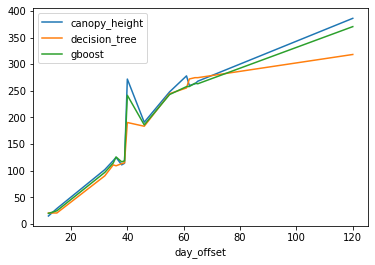

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['cultivar'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_offset','canopy_height','decision_tree','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

#plot_cultivar(cdf,'PI145619')
plot_cultivar(cdf,6000000836)

            canopy_height  decision_tree      gboost
day_offset                                          
33.0                 96.0      93.184211   95.295526
35.0                 90.0     101.326087   89.041657
36.0                 97.0     112.330508   97.400502
39.0                115.0     128.512821  121.455541
40.0                128.0     128.145455  126.195282
45.0                151.0     168.659722  152.864520
46.0                156.0     175.333333  157.547256
47.0                168.0     182.545455  168.697935
54.0                224.0     227.835294  217.687636
55.0                213.0     233.208791  215.623566
56.0                223.0     221.681818  222.594397
60.0                238.0     240.298013  239.141691
61.0                241.0     246.661417  245.439149
65.0                264.0     268.322917  264.207241
68.0                275.0     273.623229  275.614637
117.0               326.0     330.142857  330.534632


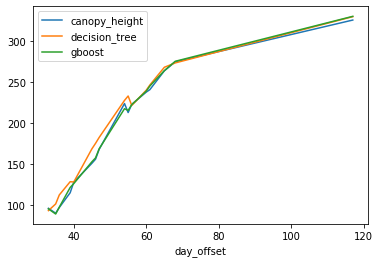

In [45]:
plot_cultivar(cdf,6000000462)

            canopy_height  decision_tree      gboost
day_offset                                          
14.0                 17.0      20.684211   19.387769
18.0                 25.0      23.906250   22.868977
32.0                 83.0      90.363636   83.121168
33.0                 92.0      91.794872   88.127969
35.0                103.0     110.971963  103.402695
36.0                103.0     109.250000   99.482699
38.0                 98.0     139.500000  108.437526
39.0                100.0     119.666667  111.939874
45.0                124.0     138.250000  148.556495


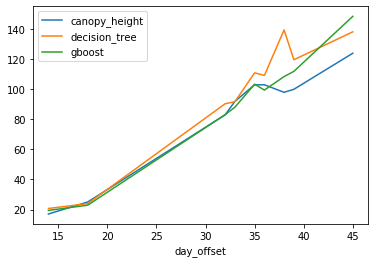

In [46]:
plot_cultivar(cdf,6000000976)

In [47]:
cdf.shape

(9441, 14)

In [48]:
# calculate the percentage error between the actual and the model
cdf['abserror_gboost'] = 100.0*abs(cdf['canopy_height']-cdf['gboost'])/cdf['canopy_height']
cdf.head()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar,date,day_offset,decision_tree,linearRegression,gboost,abserror_gboost
2017-05-13 12:00:00,15.0,4,43,2,0.435924,2.695956,1.977380,1.756464,6000000836,2017-05-13 12:00:00,12.0,20.684211,42.190178,19.914282,32.761880
2017-05-13 12:00:00,15.0,4,35,15,0.396782,3.265980,2.018623,1.941012,6000000462,2017-05-13 12:00:00,12.0,16.200000,51.816082,15.886342,5.908949
2017-05-13 12:00:00,19.0,4,42,2,0.471944,2.159610,1.809209,1.638744,6000000751,2017-05-13 12:00:00,12.0,20.684211,47.519900,22.397037,17.879142
2017-05-13 12:00:00,13.0,4,30,4,0.444099,3.042180,2.198751,1.732985,6000000916,2017-05-13 12:00:00,12.0,16.200000,44.521976,16.628871,27.914391
2017-05-15 12:00:00,17.0,4,45,2,0.462600,2.305345,1.872028,1.665387,6000000976,2017-05-15 12:00:00,14.0,20.684211,50.301563,19.387769,14.045702


Try to visualize the results across the field by finding the delta at each location between the observed and the model output.  Try to use Vega or VegaLite. Checkout the native integration explained here: https://github.com/jupyterlab/jupyterlab/blob/master/examples/vega/vega-extension.ipynb

In [49]:
import numpy as np
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])   
print(grouped['abserror_gboost'].agg(np.mean))

cultivar    column  range
6000000207  3       39        1.959442
            9       23        2.987772
6000000208  14      26       13.658223
            15      30        4.115316
6000000209  4       39        2.568294
                               ...    
6000001061  6       46        5.346371
6000001062  6       20        2.356591
            7       46        6.223122
6000001063  9       20        3.788649
            10      46        4.255562
Name: abserror_gboost, Length: 727, dtype: float64


In [50]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 6000000207, 'range': 39, 'column': 3, 'avg_error': 1.9594418336369153}


In [51]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,cultivar,range,column,avg_error
0,6000000207,39,3,1.959442
1,6000000207,23,9,2.987772
2,6000000208,26,14,13.658223
3,6000000208,30,15,4.115316
4,6000000209,39,4,2.568294


In [52]:
plotdf['avg_error'].mean()

5.196738291362434

This diagram is 50% overplotted, since each cultivar is planted twice in the plot.  We are only plotting one entry per field plot unit, but there are actually 2 plants in each unit.  

In [53]:
import altair as alt
alt.Chart(plotdf).mark_point().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar:Q', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err')
    ]
)

alt.Chart(...)

In [54]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model using quantitative cultivar').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar:Q', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [55]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [56]:
X_train

array([[6.00000084e+09, 1.20000000e+01, 4.30000000e+01, ...,
        1.97738039e+00, 1.75646406e+00, 4.35924171e-01],
       [6.00000046e+09, 1.20000000e+01, 3.50000000e+01, ...,
        2.01862316e+00, 1.94101223e+00, 3.96781790e-01],
       [6.00000075e+09, 1.20000000e+01, 4.20000000e+01, ...,
        1.80920922e+00, 1.63874449e+00, 4.71944444e-01],
       ...,
       [6.00000092e+09, 6.40000000e+01, 4.90000000e+01, ...,
        2.01394889e+00, 1.86917662e+00, 4.15079018e-01],
       [6.00000075e+09, 6.40000000e+01, 4.90000000e+01, ...,
        1.35269326e+00, 1.38938893e+00, 5.42211119e-01],
       [6.00000106e+09, 6.40000000e+01, 5.40000000e+01, ...,
        2.46242805e+00, 1.92588977e+00, 3.93302348e-01]])

As an aside, we know the input of the cultivar into the model as a quantitative independent variable is a bad idea.  

### Redo the model using a categorical variable for the cultivar

In [57]:
train_df = full_df[['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
target_df = full_df['canopy_height']
cultivar_df = full_df['cultivar']

In [58]:

# now convert the type to categorical if it needs it
train_df['cultivar'] = pd.Categorical(train_df['cultivar'])

/Users/curtislisle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [59]:
# convert the categorical 'cultivar' variable into a set of binary columns (one hot encoding)
for col in train_df.dtypes[train_df.dtypes == 'category'].index:
    for_dummy = train_df.pop(col)
    train_df = pd.concat([train_df, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [60]:
print(train_df.shape)
train_df.head()

(9441, 358)


,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,cultivar_6000000207,cultivar_6000000208,cultivar_6000000209,...,cultivar_6000001029,cultivar_6000001054,cultivar_6000001055,cultivar_6000001056,cultivar_6000001057,cultivar_6000001059,cultivar_6000001060,cultivar_6000001061,cultivar_6000001062,cultivar_6000001063
2017-05-13 12:00:00,12.0,43,2,2.695956,1.977380,1.756464,0.435924,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13 12:00:00,12.0,35,15,3.265980,2.018623,1.941012,0.396782,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13 12:00:00,12.0,42,2,2.159610,1.809209,1.638744,0.471944,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13 12:00:00,12.0,30,4,3.042180,2.198751,1.732985,0.444099,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-15 12:00:00,14.0,45,2,2.305345,1.872028,1.665387,0.462600,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X_train = train_df.values
y_train = target_df.values
print(X_train.shape)
print(y_train.shape)

(9441, 358)
(9441,)


In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor


tree = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


In [63]:
train_df['decision_tree'] = pred_tree
train_df['linearRegression'] = pred_lr
#cdf['svm'] = pred_svm
train_df['gboost'] = pred_gbr
train_df['cultivar'] = cultivar_df
train_df.head()

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,cultivar_6000000207,cultivar_6000000208,cultivar_6000000209,...,cultivar_6000001057,cultivar_6000001059,cultivar_6000001060,cultivar_6000001061,cultivar_6000001062,cultivar_6000001063,decision_tree,linearRegression,gboost,cultivar
2017-05-13 12:00:00,12.0,43,2,2.695956,1.977380,1.756464,0.435924,0,0,0,...,0,0,0,0,0,0,21.139535,62.011090,22.173630,6000000836
2017-05-13 12:00:00,12.0,35,15,3.265980,2.018623,1.941012,0.396782,0,0,0,...,0,0,0,0,0,0,18.500000,43.093656,20.788186,6000000462
2017-05-13 12:00:00,12.0,42,2,2.159610,1.809209,1.638744,0.471944,0,0,0,...,0,0,0,0,0,0,21.139535,41.080510,23.823729,6000000751
2017-05-13 12:00:00,12.0,30,4,3.042180,2.198751,1.732985,0.444099,0,0,0,...,0,0,0,0,0,0,18.500000,40.314866,20.180056,6000000916
2017-05-15 12:00:00,14.0,45,2,2.305345,1.872028,1.665387,0.462600,0,0,0,...,0,0,0,0,0,0,21.139535,16.094766,24.589799,6000000976


In [64]:
# calculate the percentage error between the actual and the model
results_df = train_df
results_df['canopy_height'] = target_df
results_df['abserror_gboost'] = 100.0*abs(results_df['canopy_height']-results_df['gboost'])/results_df['canopy_height']
results_df.head()

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,cultivar_6000000207,cultivar_6000000208,cultivar_6000000209,...,cultivar_6000001060,cultivar_6000001061,cultivar_6000001062,cultivar_6000001063,decision_tree,linearRegression,gboost,cultivar,canopy_height,abserror_gboost
2017-05-13 12:00:00,12.0,43,2,2.695956,1.977380,1.756464,0.435924,0,0,0,...,0,0,0,0,21.139535,62.011090,22.173630,6000000836,15.0,47.824203
2017-05-13 12:00:00,12.0,35,15,3.265980,2.018623,1.941012,0.396782,0,0,0,...,0,0,0,0,18.500000,43.093656,20.788186,6000000462,15.0,38.587908
2017-05-13 12:00:00,12.0,42,2,2.159610,1.809209,1.638744,0.471944,0,0,0,...,0,0,0,0,21.139535,41.080510,23.823729,6000000751,19.0,25.388047
2017-05-13 12:00:00,12.0,30,4,3.042180,2.198751,1.732985,0.444099,0,0,0,...,0,0,0,0,18.500000,40.314866,20.180056,6000000916,13.0,55.231200
2017-05-15 12:00:00,14.0,45,2,2.305345,1.872028,1.665387,0.462600,0,0,0,...,0,0,0,0,21.139535,16.094766,24.589799,6000000976,17.0,44.645875


In [65]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = train_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 6000000207, 'range': 39, 'column': 3, 'avg_error': 2.8887452175666057}


In [66]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,cultivar,range,column,avg_error
0,6000000207,39,3,2.888745
1,6000000207,23,9,3.613159
2,6000000208,26,14,8.235736
3,6000000208,30,15,2.097526
4,6000000209,39,4,7.086046


In [67]:
import altair as alt
alt.Chart(plotdf, title="Season4 - single model categorical cultivar").mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar:Q', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [68]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model using categorical cultivar").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [69]:
sorted_df = plotdf.sort_values(by=['avg_error'])
sorted_df.tail(10)

,cultivar,range,column,avg_error
289,6000000805,6,8,25.294329
504,6000000930,3,7,25.437759
305,6000000813,23,2,26.079081
496,6000000926,22,11,27.134445
259,6000000788,22,2,27.248534
152,6000000697,34,5,28.923430
495,6000000926,37,5,29.799878
481,6000000918,35,5,32.050962
560,6000000960,15,3,34.515718
561,6000000960,30,8,35.975915


            canopy_height  decision_tree     gboost
day_offset                                         
17.0                 18.0      20.589744  15.926290
19.0                 19.0      25.586466  20.134351
34.0                 75.0      98.231092  79.912336


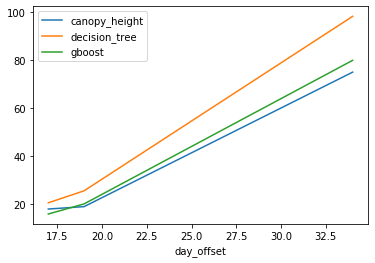

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['cultivar'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_offset','canopy_height','decision_tree','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

plot_cultivar(cdf,6000000960)

So it makes sense that this cultivar would be badly modeled because there are only a few datapoints.  The model doesn't have much to go on. 

### Address Overplotting

Next, lets address the overplotting.  Is there really overplotting going on, or is there only one plant per square? If we must,  We can make a pass through the data and double the number of columns.  The first time we encounter a (range,col) pair, plot it at (range,col*2), the second time we counter one, plot it at (range,col*2+1):

In [71]:
plotdf.head()

,cultivar,range,column,avg_error
0,6000000207,39,3,2.888745
1,6000000207,23,9,3.613159
2,6000000208,26,14,8.235736
3,6000000208,30,15,2.097526
4,6000000209,39,4,7.086046


In [72]:
plotdf.loc[(plotdf['column'] == 3) & (plotdf['range']==10)]

,cultivar,range,column,avg_error
199,6000000725,10,3,7.81228


In [73]:
plotdf.loc[(plotdf['column'] == 10) & (plotdf['range']==42)]

,cultivar,range,column,avg_error
292,6000000806,42,10,9.372365


So, there is only one value per square.  Cool, the previous plots are valid...

## Plot accuracies for separate models per location

In [74]:
full_df.head()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,cultivar,date,day_offset,decision_tree,linearRegression,gboost,abserror_gboost
2017-05-13 12:00:00,15.0,4,43,2,0.435924,2.695956,1.977380,1.756464,6000000836,2017-05-13 12:00:00,12.0,20.684211,42.190178,19.914282,32.761880
2017-05-13 12:00:00,15.0,4,35,15,0.396782,3.265980,2.018623,1.941012,6000000462,2017-05-13 12:00:00,12.0,16.200000,51.816082,15.886342,5.908949
2017-05-13 12:00:00,19.0,4,42,2,0.471944,2.159610,1.809209,1.638744,6000000751,2017-05-13 12:00:00,12.0,20.684211,47.519900,22.397037,17.879142
2017-05-13 12:00:00,13.0,4,30,4,0.444099,3.042180,2.198751,1.732985,6000000916,2017-05-13 12:00:00,12.0,16.200000,44.521976,16.628871,27.914391
2017-05-15 12:00:00,17.0,4,45,2,0.462600,2.305345,1.872028,1.665387,6000000976,2017-05-15 12:00:00,14.0,20.684211,50.301563,19.387769,14.045702


In [76]:
import warnings
warnings.filterwarnings(action='ignore')


In [77]:
gbr_models = {}
predictions = {}
count = 0
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    #print(name)
    # pick the features to use for training
    train_df = group[['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
    # identify the 'target' feature to try to predict
    target_df = group['canopy_height']
    X_train = train_df.values
    y_train = target_df.values
    # train a model for this cultivar in this location and store the trained model in a dictionary
    gbr_models[name] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)
    gbr_pred = gbr_models[name].predict(X_train)
    count += 1
    # add the model results back into the dataframe so we can plot the actual and predicted against all the indepedent variables
    train_df['gboost'] = gbr_pred
    #put the actual target value back in the dataframe so we can plot results
    train_df['canopy_height'] = target_df
    # store the predicted results in the same dictionary organization and the trained models
    predictions[name] = train_df
print('finished generating',count,'models')

finished generating 727 models


In [45]:
predictions['canopy_height'] = full_df['canopy_height']

727 models were generated. This is two plants per cultivar, planted in different locations. Lets plot the whole field..

In [48]:
count = 0
for key in predictions.keys():
    print(predictions[key])
    count += 1
    if count>2:
        break

                       cultivar  day_offset  range  column  leaf_angle_alpha  \
2017-05-16 12:00:00  6000000207        15.0     39       3          3.029223   
2017-05-25 12:00:00  6000000207        24.0     39       3          2.109788   
2017-06-02 12:00:00  6000000207        32.0     39       3          2.447258   
2017-06-03 12:00:00  6000000207        33.0     39       3          3.109602   
2017-06-05 12:00:00  6000000207        35.0     39       3          2.976765   
2017-06-06 12:00:00  6000000207        36.0     39       3          2.805701   
2017-06-08 12:00:00  6000000207        38.0     39       3          3.269036   
2017-06-09 12:00:00  6000000207        39.0     39       3          2.506393   
2017-06-10 12:00:00  6000000207        40.0     39       3          3.163247   
2017-08-25 12:00:00  6000000207       116.0     39       3          1.934727   
2017-08-26 12:00:00  6000000207       117.0     39       3          1.749690   
2017-08-29 12:00:00  6000000207       12

In [46]:
predictions[(6000000207,3,39)]

,cultivar,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,gboost,canopy_height
2017-05-16 12:00:00,6000000207,15.0,39,3,3.029223,1.961442,1.870532,0.420787,22.004380,22.0
2017-05-25 12:00:00,6000000207,24.0,39,3,2.109788,1.673649,1.710402,0.461486,48.003689,48.0
2017-06-02 12:00:00,6000000207,32.0,39,3,2.447258,1.713407,1.837392,0.431054,89.002743,89.0
2017-06-03 12:00:00,6000000207,33.0,39,3,3.109602,1.913697,1.942567,0.403784,95.002346,95.0
2017-06-05 12:00:00,6000000207,35.0,39,3,2.976765,1.894488,1.910338,0.409748,113.002056,113.0
2017-06-06 12:00:00,6000000207,36.0,39,3,2.805701,1.866598,1.825539,0.435253,116.001794,116.0
2017-06-08 12:00:00,6000000207,38.0,39,3,3.269036,1.791071,2.108108,0.383240,132.001485,132.0
2017-06-09 12:00:00,6000000207,39.0,39,3,2.506393,1.684057,1.881935,0.432157,141.001287,141.0
2017-06-10 12:00:00,6000000207,40.0,39,3,3.163247,1.875412,1.972441,0.410376,150.000832,150.0
2017-08-25 12:00:00,6000000207,116.0,39,3,1.934727,1.635415,1.670653,0.458132,316.996744,317.0


In [47]:
# calculate the percentage error between the actual and the model
predictions['abserror_gboost'] = 100.0*abs(predictions['canopy_height']-predictions['gboost'])/predictions['canopy_height']
predictions.head()

KeyError: 'gboost'

In [318]:
import numpy as np

count = 0
plotlist = []
for key in predictions.keys():
    mark = {}
    mark['cultivar'] = key[0]
    mark['range'] = key[2]
    mark['column'] = key[1]
    df = predictions[key]
    df['abserror_gboost'] = 100.0*abs(df['canopy_height']-df['gboost'])/df['canopy_height']
    mark['avg_error'] = df['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    count += 1
        
print(plotlist[0:5])

[{'cultivar': 6000000207, 'range': 39, 'column': 3, 'avg_error': 0.00244314741814779}, {'cultivar': 6000000207, 'range': 23, 'column': 9, 'avg_error': 0.0005775131558959814}, {'cultivar': 6000000208, 'range': 26, 'column': 14, 'avg_error': 0.0}, {'cultivar': 6000000208, 'range': 30, 'column': 15, 'avg_error': 0.0005336198421920244}, {'cultivar': 6000000209, 'range': 39, 'column': 4, 'avg_error': 0.002820469437681125}]


/Users/curtislisle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [319]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()
len(plotdf)

727

In [321]:
import altair as alt
alt.Chart(plotdf, title="Season4 - model per location categorical cultivar").mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar:Q', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [322]:
plotdf.head()

,avg_error,column,cultivar,range
0,0.002443,3,6000000207,39
1,0.000578,9,6000000207,23
2,0.000000,14,6000000208,26
3,0.000534,15,6000000208,30
4,0.002820,4,6000000209,39


In [324]:

alt.Chart(plotdf,title="Histogram of error (%) of a model per location using categorical cultivar").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)